<a href="https://colab.research.google.com/github/sunset0316/Human_Emotions_Detectors/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Wandb Installation

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 181 kB 54.8 MB/s 
     |████████████████████████████████| 145 kB 56.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f2376b6a40c79937e61f087c8729fe99cedfeaadc2e4a3db11cef68035dcc1a5
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project="Emotion-Detection", entity="neuralearn")

wandb: Currently logged in as: neuralearn. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.config = CONFIGURATION

# 2 - Packages and Libraries

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

# 3 - Configuration

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 128,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

# 4 - Dataset Management


## Dataset Downloading

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 96% 297M/309M [00:04<00:00, 51.0MB/s]
100% 309M/309M [00:04<00:00, 68.1MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

## Dataset Loading

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

## 4. Dataset Visualization

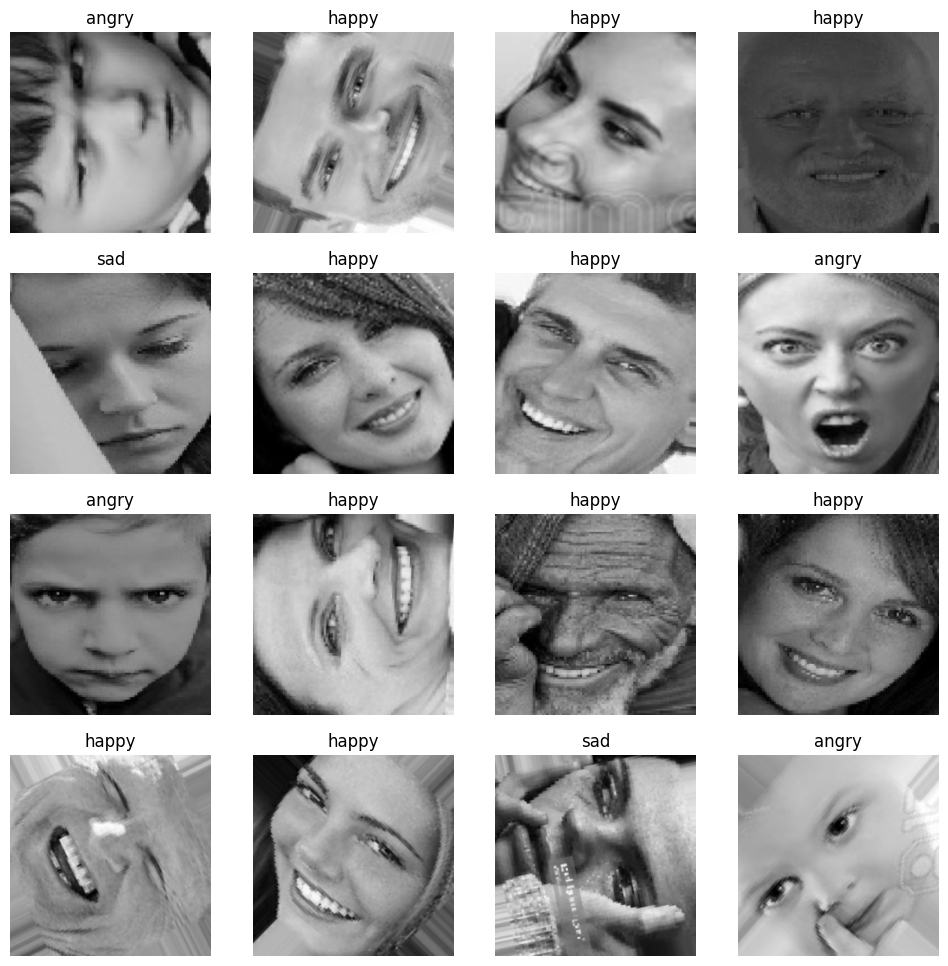

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## 5. Dataset Augmentation

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

### Cutmix Augmentation

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [ ]:
# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [ ]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

# 5 - Modeling

## 5.1 - Lenet

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

## 5.2 - ResNet 34

### 5.2.1 - CustomConv2D

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

### 5.2.2 - Residual Block

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

### 5.2.3 - Complete NetWork

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

## 5.3 - Transfer Learning with EfficientNet

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

## 5.4 - Transfer Learning with MobileNetV2

In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

## 5.5 - FineTuning EfficientNet

In [ ]:
backbone.trainable = True

In [ ]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

In [ ]:
finetuned_model.summary()

## 5.6 - Vision Transformer

### Understand Patch Encoder

In [ ]:
# 加载一张图片并进行大小调整，将图像调整为预定义的大小。CONFIGURATION["IM_SIZE"] 用来指定图片大小。
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [ ]:
# 使用 TensorFlow 的 extract_patches 函数将图像切割成小块（patches）
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0), # 这里先对 test_image 进行了维度扩展，将其从 (h,w,c) 扩展为 (1,h,w,c)，添加了一个维度表示批次 Batch 大小。
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1], # 设置了提取的小块的大小。前后两个 1 表示批次和通道维度大小。
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1], # 设置了一个滑动窗口的大小。
                           rates=[1, 1, 1, 1], # 这里设置了窗口在图像上滑动的速率。[1, 1, 1, 1] 表示在所有维度上的滑动速率均为1，即没有跳跃。
                           padding='VALID') #  'VALID'，表示不进行任何填充，只在图像边缘内提取小块。

In [ ]:
# 对从图像中提取的小块（patches）的形状调整操作。

# 目前 patches.shape 是 (1,16,16,768)
# 1 表示一个小块的数量
# 16,16 表示每个小块大小是 16x16
# 768 表示特征维度，RGB，256+256+256=768
print(patches.shape)

# 将原本的小块张量 (1, 16, 16, 768) 重新组织成一个形状为 (1, 256, 768)
# patches.shape[0]  ：获取 patches 张量的第一个维度的大小，表示小块的数量。
# -1                ：表示在第二个维度上自动计算大小，以保持原有的元素总数不变。
# 768               ：指定了新的第三个维度的大小，这是特征嵌入的维度。
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


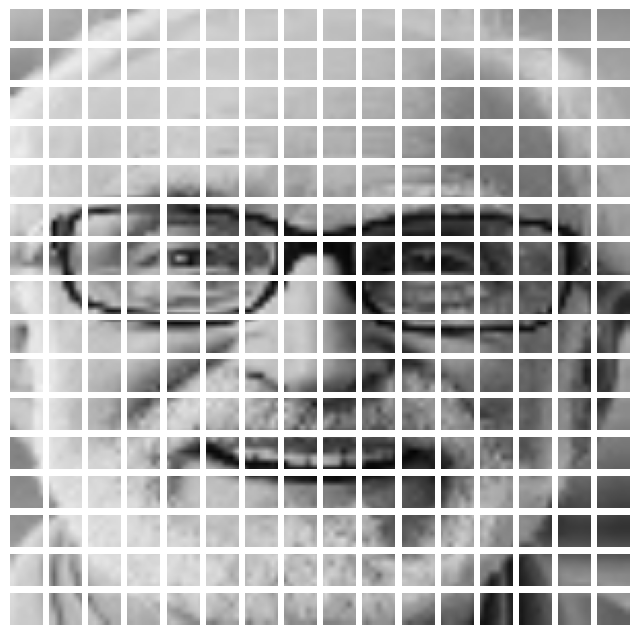

In [ ]:
# 可视化每组小块 patches
plt.figure(figsize = (8,8))
for i in range(patches.shape[1]):
    # 16, 16 表示将子图划分成 16 行 16 列的网格。
    # i + 1 表示当前子图的索引，从 1 开始。
    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

### Create PatchEncoder

步骤：
1. 查看 ViT 的结构图
2. 构造




In [ ]:
class PatchEncoder(Layer):
  # N_PATCHES 表示图像被切割成的小块的数量。
  # HIDDEN_SIZE 表示隐藏层的维度大小。
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    # 调用了父类 Layer 的构造函数，同时设置了层的名称为 'patch_encoder'
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    # Details of ViT Model variants
    # ---------------------------------------------------------------------
    # Model       Layers      Hidden_size_D     MLP_size    Heads   Params
    # ---------------------------------------------------------------------
    # ViT-Base    12          768               3072        12       86M
    # ViT-Large   24          1024              4096        16       307M
    # ViT-Huge    32          1280              5120        16       632M

    # 注意：我们忽略了（不构造）Position Embedding 为 0 的那个维度（0 和 *）

    # 不考虑 Batch 的情况下，我们目前的输入是 (256, 768)， 注意：这里的 768 和 ViT Model 不是同一个东西
    self.linear_projection = Dense(HIDDEN_SIZE) # ViT 里的 Linear Projection of Flattened Patches
    # ViT 里的 Position Embedding
    # 此处去 "了解embedding_input" 目录
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE ) # 的到的输出是 (B,P,H)
    self.N_PATCHES = N_PATCHES

  # 使用前面了解到的 patches 函数，稍作修改
  def call(self, x):
    patches = tf.image.extract_patches(
        images=x, # 这次我们不需要 Expand_Dim, 因为此次的输入自动会添加 Batch 维度。
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    # 一样的 reshape 操作, 但是稍作修改
    # 假设目前的 patches 形状是 (Batch, 256, 768), 256 是块，768是特征
    # 我们转换成以下方式
    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
    # 创建了一个从 0 到 self.N_PATCHES - 1 的序列，表示图像块的位置。
    # 这个序列会作为位置编码的输入，以便为每个图像块生成对应的位置信息。
    # 在图像处理中，因为图像的结构通常是紧密排列的像素，位置之间的关系比较直观，所以常常选择间隔为1，即相邻位置之间的距离是相等的。
    # 在文本处理中，有时会考虑到文本中的词与词之间可能存在较远的关系，这种关系可能需要更大的距离来捕捉。
    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    # 这边就是 Linear Projection 的输出和 Positional Embedding 做拼接
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

### Understand Embedding

In [ ]:
# 以下是 TensorFlow 提供的 Embedding 的 Example

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
input_array = np.random.randint(1000, size=(32, 10))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)

# ---------------------------------------------------------------
#                               解释
# ---------------------------------------------------------------
model = tf.keras.Sequential()
# 1000  : 词汇表大小为1000
# 64    : 每个词嵌入到64维的向量空间中
# 10    : 表示 输入序列长度为10。
model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
# 生成随机的数据矩阵，形状为(32,0), 范围在[0,1000]
input_array = np.random.randint(1000, size=(32, 10))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape) # 输出就是 (32,10,64)

# 32 是批次大小（batch size），表示同时处理的样本数。
# 10 是输入序列的长度，即每个样本的序列中包含的词汇数。
# 64 是嵌入向量的维度，即每个词汇被嵌入到的向量空间的维度。

# 图表示就是

# A   B   C   D   E   F ... J
# 1   1   1   1   1   1     1
# .   .   .   .   .   .     .
# .   .   .   .   .   .     .
# 63  63  63  63  63  63    63
# 64  64  64  64  64  64    64

# ---------------------------------------------------------------
#                         我们的需求
# ---------------------------------------------------------------
# 我们的目的是达到 Batch, 256, 768. 再回顾256是块，768是HIDDEN_SIZE（不是特征）
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(256, 768))
input_array = np.random.randint(1000, size=(1, 256))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape) # 输出就是 (1, 256, 768) (Batch, Patch, Hidden_size)

### Create TransformerEncoder

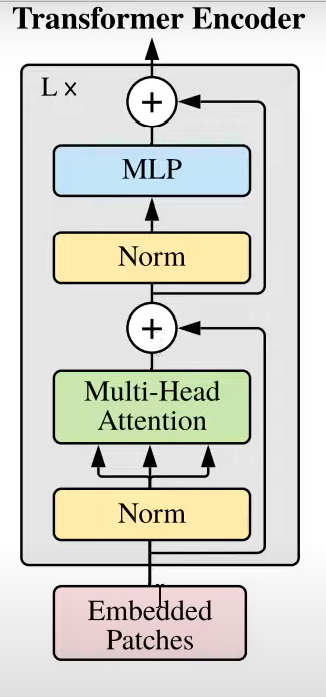

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

### Complete Vision Transformer Model

In [ ]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name='vision_transformer')
    # 调用父类构造函数，设置模型的名称为'vision_transformer'

    self.N_LAYERS = N_LAYERS
    # 初始化变量self.N_LAYERS，表示Transformer编码器的层数

    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    # 创建一个Patch编码器的实例，N_PATCHES是块数，HIDDEN_SIZE是嵌入维度

    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    # 创建一个包含多个Transformer编码器的列表，其中N_LAYERS表示编码器的层数，
    # N_HEADS表示注意力头数，HIDDEN_SIZE表示隐藏层维度
    # 另一种格式
    # self.trans_encoders = []
    # for _ in range(N_LAYERS):
    # encoder = TransformerEncoder(N_HEADS, HIDDEN_SIZE)
    # self.trans_encoders.append(encoder)

    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    # 创建一个Dense层（全连接层），将输入维度变换为N_DENSE_UNITS，
    # 使用GELU激活函数

    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    # 创建第二个Dense层，同样将输入维度变换为N_DENSE_UNITS，
    # 使用GELU激活函数

    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')
    # 创建第三个Dense层，将输入维度变换为分类数目，使用softmax激活函数
    # 这里的CONFIGURATION["NUM_CLASSES"]应该是预定义的类别数目

  def call(self, input, training=True):
    # 定义模型的前向传播函数，接收输入input和是否训练标志training

    x = self.patch_encoder(input)
    # 将输入通过Patch编码器进行处理，得到表示特征x

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
      # 将表示特征x通过多个Transformer编码器进行处理

    x = Flatten()(x)
    # 对x进行扁平化，将多维的表示转换为向量

    x = self.dense_1(x)
    # 通过第一个Dense层对扁平化后的特征x进行线性变换

    x = self.dense_2(x)
    # 通过第二个Dense层再次对特征x进行线性变换

    return self.dense_3(x)
    # 通过第三个Dense层得到最终的分类结果，返回模型输出


In [ ]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))
# 示例输入。这将调用模型的call方法，对输入进行前向传播。

In [ ]:
vit.summary()

# 后面就可以训练模型的
# 要记住， Transformer模型数据庞大，效果才会好

## 5.7 - HuggingFace ViT
人工智能和自然语言处理（NLP）社区和平台，致力于分享、开发和部署 NLP 模型和工具。

### Installation

In [ ]:
!pip install transformers

### Training

In [ ]:
# 定义一个图像处理的序列，包括缩放、归一化和通道转置
resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))
])

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig

configuration = ViTConfig()
configuration.output_attentions = True

# 从预训练模型中加载 ViT 模型
base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    config = configuration,
    )
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)['attentions'] # 提取 ViT 模型的注意力信息

# 创建一个新的 Keras 模型，输入是原始图像，输出是 ViT 模型的注意力信息
model = tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# 读取测试图像
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [ ]:
hf_model(tf.expand_dims(test_image, axis = 0))  # 使用模型进行预测

In [ ]:
hf_model.summary() # 打印模型的概要信息

### Get Attention Map

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig

# 建一个 ViTConfig 对象，用于配置 ViT 模型的行为和特性。
configuration = ViTConfig()
# 设置 ViT 模型在预测时输出注意力信息。
configuration.output_attentions = True

# 从 Hugging Face 模型库中加载预训练的 ViT 模型。
base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k", # 指定了要加载的模型名称
    config = configuration, # 定了模型的配置
    )
inputs = Input(shape = (256,256,3))
# 通过之前定义的图像处理序列
x = resize_rescale_hf(inputs) # 对输入图像进行预处理。
x = base_model.vit(x)['attentions'] # 将经过预处理的图像输入到 ViT 模型中，并从模型输出中提取注意力信息。

model = tf.keras.Model(inputs=inputs, outputs=x)

# 6 - Training

## Class Weighting

In [ ]:
n_sample_0 = 1525 # angry
n_sample_1 = 3019 # happy
n_sample_2 = 2255 # sad

In [ ]:
class_weights = {0:6799/n_sample_0, 1: 6799/n_sample_1, 2: 6799/n_sample_2}

In [ ]:
print(class_weights)

## Callbacks

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

In [ ]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)


    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)


    wandb.log({"Model Results" : val_table})


## Train

In [ ]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
pretrained_model.save("/content/drive/MyDrive/Bang/eff_keras.h5")

## Ensembling

In [ ]:
inputs = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

y_1 = resnet_34(inputs)
y_2 = pretrained_model(inputs)

output = 0.5*y_1 + 0.5*y_1

ensemble_model = Model(inputs = inputs, outputs = output)

# 7 - Evaluation

In [ ]:
model.load_weights('best_weights')

In [ ]:
hf_model.evaluate(validation_dataset)

# 8 - Testing

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(pretrained_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(pretrained_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

## Confusion Matrix

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(pretrained_model(im))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# 9 - Visualization

## Feature Map Visualization

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights= None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),

)

In [ ]:
vgg_backbone.summary()

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

In [ ]:
print(len(f_maps))

In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")


## GradCam

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

In [ ]:
pretrained_model.load_weights('/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5')

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

In [ ]:
preds = pretrained_model.predict(img_array)

In [ ]:
print(preds)

In [ ]:
np.argmax(preds[0])

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pooled_grads.shape)

(2048,)


In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

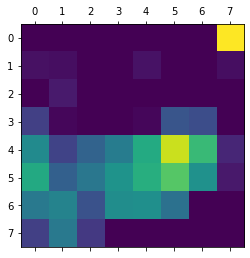

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

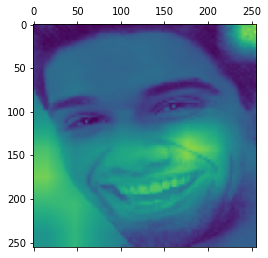

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)

# 10 - Exporting to Onnx format

In [ ]:
hf_model.save('vit_finetuned')

INFO:tensorflow:Assets written to: vit_finetuned/assets


INFO:tensorflow:Assets written to: vit_finetuned/assets


In [ ]:
hf_model.save('vit_finetuned.h5')

## Installation

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 12.6 MB/s 
     |████████████████████████████████| 13.1 MB 43.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115.3 MB 2.8 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 


In [ ]:
import onnxruntime as rt
rt.get_device()

'GPU'

## Conversion

### From TensorFlow SavedModel

In [ ]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-05-25 13:11:26,360 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-05-25 13:11:34,252 - INFO - Signatures found in model: [serving_default].
2022-05-25 13:11:34,252 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-05-25 13:11:34,253 - INFO - Output names: ['dense']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-05-25 13:11:45,495 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-05-25 13:11:50,911 - INFO - Using tenso

### From Keras Model

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "lenet_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model_for_export, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
print(output_names)

['dense_2']


In [ ]:
output_names = ['dense']

## Inference

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = test_image.astype(np.float32)

im = np.expand_dims(im, axis = 0)

In [ ]:
N_PREDICTIONS = 10

### Benchmarking Onnx

In [ ]:
providers=['CPUExecutionProvider' ]
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
t1 = time.time()

for _ in range(N_PREDICTIONS):
  onnx_pred = m.run(['dense'], {"input": im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.2902926683425903


In [ ]:
print(onnx_pred)

[array([[0.00484342, 0.00301275, 0.99214387]], dtype=float32)]


### Benchmarking TF

In [ ]:
t1 = time.time()
for _ in range(N_PREDICTIONS):
  hf_model(im)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.7937646389007569


In [ ]:
tf, gpu = 0.15s
tf, cpu = 0.8s
tf_size = 1000MB

onnx, cpu = 0.5s
onnx, gpu = 0.025s
onnx_size = 328MB

onnx_quantized, cpu = 0.4s
onnx_quantized, gpu = 0.3s
onnx_quantized_size = 83MB

In [ ]:
0.8/0.35

2.285714285714286

## Quantization with Onnx

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = '/content/eff_keras.onnx'
model_quant = '/content/eff_quantized.onnx'

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[m

### Accuracy Drop due to Quantization

In [ ]:
def accuracy(model):
  total, acc = 0,0
  for im, label in validation_dataset:
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acc += 1

    total += 1
  return acc/total

In [ ]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)
print(accuracy(m_q))
print(accuracy(m))

0.9051799824407375
0.9051799824407375


In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 27.0 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 86 kB 8.0 MB/s 


In [ ]:
import onnxruntime as rt

In [ ]:
providers=['CPUExecutionProvider' ]
m_q = rt.InferenceSession("/content/drive/MyDrive/Bang/eff_quantized.onnx", providers=providers)

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/553112.jpg"
test_image = cv2.imread(img_path)
print(test_image.shape)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = np.float32(test_image)
img_array = np.expand_dims(im, axis = 0)
print(img_array.shape)

(90, 90, 3)
(1, 256, 256, 3)


In [ ]:
onnx_pred = m_q.run(['dense'], {"input":img_array})
print(np.argmax(onnx_pred[0][0]))

fastapi==0.87.0
numpy==1.23.4
onnxruntime==1.13.1
Pillow==9.3.0

1


In [ ]:
!pip install onnxruntime==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 


# 11 - Pruning

In [ ]:
# Helper function uses `prune_low_magnitude` to make only the
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
  print(layer.name)
  if layer.name != "rescaling_1" and layer.name != "normalization" and layer.name != "sequential_1":

    pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.2,
                  final_sparsity=0.8, begin_step=0, end_step=2000),

          }

    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    lenet_model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

sequential_1
conv2d
batch_normalization_1
max_pooling2d
dropout_37
conv2d_1
batch_normalization_2
max_pooling2d_1
flatten
dense_4
batch_normalization_3
dropout_38
dense_5
batch_normalization_4
dense_6
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 prune_low_magnitude_conv2d   (None, 254, 254, 6)      332       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_batch_n  (None, 254, 254, 6)      25        
 ormalization_1 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 127, 127, 6)  

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


 _37 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv2d_  (None, 125, 125, 16)     1746      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_batch_n  (None, 125, 125, 16)     65        
 ormalization_2 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 62, 62, 16)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 61504)            1         
  (PruneLowMagnitude)                                            
          

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

model_for_pruning = prune_low_magnitude(model_for_pruning, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

ValueError: ignored

In [ ]:
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(training_dataset,
                      validation_data = validation_dataset,
                      epochs=3,
                      callbacks=callbacks)

Epoch 1/3
213/213 [==============================] - 37s 149ms/step - loss: 0.9830 - accuracy: 0.5563 - val_loss: 1.0246 - val_accuracy: 0.5215
Epoch 2/3
213/213 [==============================] - 31s 142ms/step - loss: 0.8018 - accuracy: 0.6491 - val_loss: 1.0799 - val_accuracy: 0.5430
Epoch 3/3
213/213 [==============================] - 28s 131ms/step - loss: 0.7204 - accuracy: 0.6869 - val_loss: 1.0230 - val_accuracy: 0.5079


In [ ]:
lenet_model.save("lenet.h5")

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

#_, pruned_keras_file = tempfile.mkstemp('eff_pruned.h5')
tf.keras.models.save_model(model_for_export, "lenet_pruned_1.h5", include_optimizer=False)
#print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
hf_model.save('hf.h5')

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  with zipfile.ZipFile("lenet_keras.zip", 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return "good"#os.path.getsize(zipped_file)

In [ ]:
get_gzipped_model_size("lenet_pruned_1.h5")

'good'

# TFRecords

In [ ]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
# val_dataset = (
#     validation_dataset
#     .unbatch()
# )

In [ ]:
train_dataset

In [ ]:
# val_dataset

In [ ]:
# 创建序列化的TFRecord样本
def create_example(image, label):

  # 代码使用tensorflow.train模块中的Feature类定义了一个bytes_feature，
  # 它可以存储字节类型的数据（在这里用于存储图像）。
  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  # 代码定义了一个int_feature，
  # 它可以存储整数类型的数据（在这里用于存储标签）。
  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  # 创建一个样本example，样本中包含了两个特征，即图像和标签。
  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  # SerializeToString()方法将样本转换为适合写入TFRecord文件的字节字符串。
  return example.SerializeToString()

In [ ]:
# 表示将要创建的TFRecord分片（shard）的数量。
NUM_SHARDS = 10
# 定义了TFRecord文件的路径模式。
# {}占位符将在后面被实际的分片号替换。
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  # 将图像转换为uint8数据类型。它确保图像数据在编码前处于正确的格式。
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  # 将图像编码为JPEG格式的字节字符串。
  # 这一步准备图像数据以便存储在TFRecord文件中。
  image = tf.io.encode_jpeg(image)
  # 返回编码后的图像和标签的最大值索引。
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image) # 对train_dataset中的每个样本应用encode_image函数。
)

# 具体步骤如下：

# 1. 从train_dataset中依次取出每个样本。
# 2. 将每个样本中的图像和标签传递给encode_image函数进行处理。
# 3. encode_image函数对图像进行编码为JPEG格式，并提取标签的最大值索引。
# 4. 最终得到一个新的数据集encoded_dataset，其中每个样本的图像被编码为JPEG格式，而标签则是提取的最大值索引。

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      # encoded_dataset通过.shard()方法被分片为NUM_SHARDS个分片。
      .shard(NUM_SHARDS, shard_number)
      # 将分片后的数据转换为numpy迭代器。
      .as_numpy_iterator()
  )

  # 创建一个TFRecord写入器，
  # 并以指定的文件路径PATH.format(shard_number)打开对应的分片文件，
  # 其中shard_number是当前分片的序号
  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    # 使用sharded_dataset中的数据迭代器，
    # 将编码后的图像encoded_image和编码后的标签encoded_label解包
    for encoded_image, encoded_label in sharded_dataset:
      # 调用create_example函数来创建样本example，
      # 它将编码后的图像和标签作为输入参数。
      example = create_example(encoded_image, encoded_label)
      # 将样本example写入到当前分片的TFRecord文件中。
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )


In [ ]:
# 接收一个序列化的TFRecord样本example作为输入。
def parse_tfrecords(example):

    # 定义了一个特征描述字典
    feature_description = {
        # 定了从TFRecord中解析的特征及其数据类型。
        "images": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    # 解析单个样本，
    # 从序列化的TFRecord数据中提取"images"和"labels"特征。
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)